In [1]:
%load_ext autoreload

In [2]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
import colorcet as cc

import torch
import torch.distributions as dist

import umap.umap_ as umap

from hmmlearn import hmm
from model import HMMPoisson
from utils import *

# Import data

In [3]:
df = pd.read_csv("df.csv")
X_pd = df.drop(columns= ["headAngel", "sin_angel", "cos_angel"]) # Droping unimportant columns and head angel
y = df.headAngel

# Remove inactive neurons

In [4]:
df_pure = df[~np.isnan(df["headAngel"])]

X_pure = df_pure.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y_pure = df_pure.headAngel

X_pure = X_pure.loc[:,X_pure.sum(axis=0) > 100]

In [5]:
X_pure.shape

(3553, 59)

# Vizualization

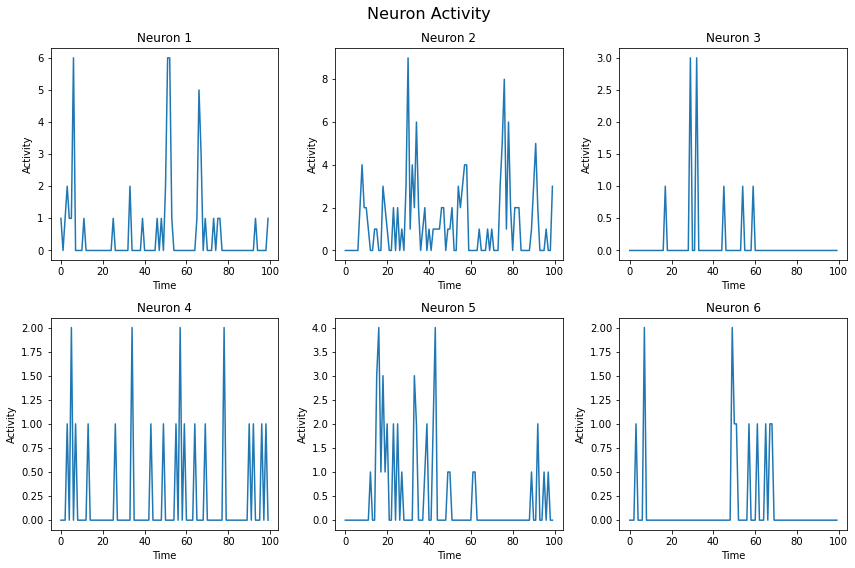

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Neuron Activity", fontsize=16)

t = 100 

data = X_pure
i = 0
for cell in data.columns[0:6]:
    row, col = divmod(i,3)
    ax = axes[row, col]
    
    ax.plot(range(t), data[cell][0:t])
    ax.set_title(f"Neuron {i+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Activity")
    i += 1

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

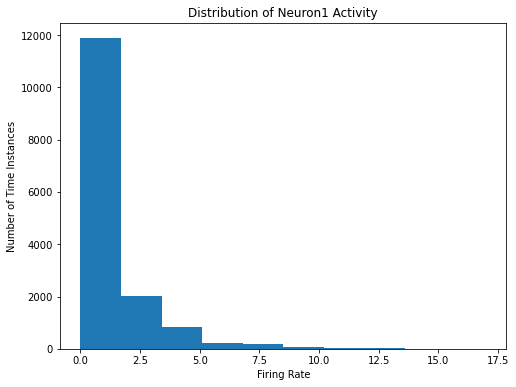

In [7]:
# Create a bar plot for the distribution of Neuron1's activity
plt.figure(figsize=(8, 6))

plt.hist(df["cell_0"])

# Set labels and title
plt.xlabel('Firing Rate')
plt.ylabel('Number of Time Instances')
plt.title('Distribution of Neuron1 Activity')

# Show the plot
plt.show()


# UMAP

In [13]:
X_scaled = StandardScaler().fit_transform(X_pure)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

In [19]:
def map_list_to_segments(values, num_segments=10):
    segment_indices = []

    for value in values:
        if value < 0:
            value = 0
        elif value >= 2 * np.pi:
            value = 2 * np.pi - 1e-6  # To ensure that 2π gets mapped to the last segment.
        
        segment_width = (2 * np.pi) / num_segments
        segment_index = int(value / segment_width)
        segment_indices.append(segment_index)

    return segment_indices

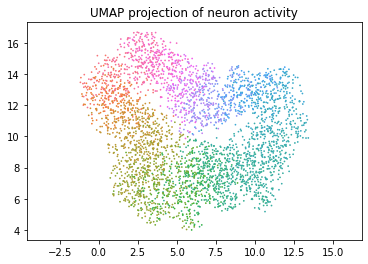

In [20]:
segment_hd = map_list_to_segments(y_pure, len(y_pure))
custom_palette = sns.color_palette("husl", len(segment_hd))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in segment_hd], s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

# Modeling

## Own model

In [16]:
n_states = 10
X = torch.tensor(X_pd.values)
n_retraining = 1
m_dimensions = X.shape[1]

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = HMMPoisson(n_states = n_states, m_dimensions=m_dimensions, verbose=True, max_itterations = 8, tolerance = 500)
    model.fit(X)

    model_list.append(model)
    score_list.append(model.forward(X).item())
    print(f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

1 -2309528.2500  +inf
2 -1079146.1250  +1230382.125
3 -941929.5625  +137216.5625
4 -916919.6250  +25009.9375
5 -905170.1250  +11749.5
6 -900882.8750  +4287.25
7 -900040.7500  +842.125
8 -899669.8750  +370.875
Converged (change in log likelihood within tolerance)


: 

## Sklearn model

In [6]:
n_states = 10
X = X_pd
n_retraining = 5

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = hmm.PoissonHMM(n_components = n_states, verbose=True, random_state = idx, n_iter=15, tol = 500)
    try:
        model.fit(X)
    except:
        score_list.append(-np.inf)
        continue
    
    model_list.append(model)
    score_list.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

         1 -4842511.00079125             +nan
         2 -1023399.88859411 +3819111.11219714
         3 -931326.67417863  +92073.21441548
         4 -919769.23498782  +11557.43919081
         5 -916702.15440384   +3067.08058397
         6 -914673.60189721   +2028.55250663
         7 -912617.39426919   +2056.20762802
         8 -909494.18504166   +3123.20922754
         9 -907358.75547089   +2135.42957076
        10 -906333.89859962   +1024.85687127
        11 -905772.32241912    +561.57618050
        12 -905466.02758331    +306.29483581


Converged: True		Score: -905246.3141337812


         1 -4779046.88344261             +nan
         2 -1059393.36007983 +3719653.52336278
         3 -947829.98567522 +111563.37440461
         4 -924558.27755685  +23271.70811837
         5 -914029.96174735  +10528.31580949
         6 -908212.99790242   +5816.96384493
         7 -905290.62915655   +2922.36874587
         8 -903425.46541039   +1865.16374615
         9 -900699.07152083   +2726.39388956
        10 -897615.19083371   +3083.88068712
        11 -896442.30488002   +1172.88595369
        12 -896096.60298277    +345.70189725


Converged: True		Score: -895881.483104538


         1 -5228278.72275427             +nan
         2 -1069526.89116329 +4158751.83159098
         3 -983818.72647657  +85708.16468673
         4 -950553.97878082  +33264.74769574
         5 -938071.29394536  +12482.68483546
         6 -924526.62178651  +13544.67215885
         7 -917320.28025236   +7206.34153415
         8 -913113.30997993   +4206.97027244
         9 -910087.69101314   +3025.61896679
        10 -908861.27884523   +1226.41216791
        11 -908310.49290733    +550.78593789
        12 -908016.64413422    +293.84877311


Converged: True		Score: -907825.9781659812


         1 -4830534.18740729             +nan
         2 -1050133.08870484 +3780401.09870245
         3 -938875.34718542 +111257.74151942
         4 -921036.35599798  +17838.99118744
         5 -914902.89478062   +6133.46121736
         6 -909707.85437869   +5195.04040192
         7 -907507.67295758   +2200.18142111
         8 -906706.75519522    +800.91776236
         9 -906205.05769270    +501.69750252
        10 -905760.83757225    +444.22012045


Converged: True		Score: -905236.4806771984


         1 -4948960.76101310             +nan
         2 -1067392.14875790 +3881568.61225520
         3 -971192.30409294  +96199.84466496
         4 -943047.08651608  +28145.21757687
         5 -932463.33704253  +10583.74947355
         6 -929479.22697757   +2984.11006496
         7 -928357.85500037   +1121.37197720
         8 -927370.80782692    +987.04717345
         9 -926291.18886051   +1079.61896642
        10 -925669.20937753    +621.97948298
        11 -925306.50231450    +362.70706303


Converged: True		Score: -924974.4525606391
--- 131.70023155212402 seconds ---


## Get best prediction

In [7]:
model = model_list[np.argmax(score_list)]
states_head = model.predict(X)

In [10]:
pd.DataFrame(states_head).value_counts()

5    2083
0    1997
3    1636
2    1619
8    1501
6    1427
1    1413
9    1352
7    1239
4     976
Name: count, dtype: int64

# Visualizing the Result

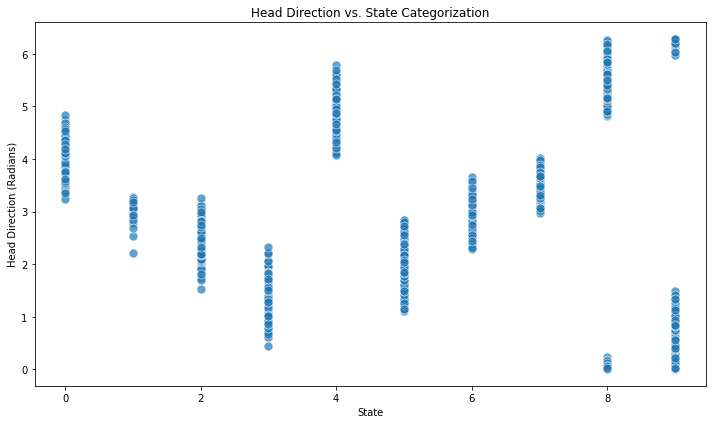

In [11]:
scatterplot_with_color(y, states_head)

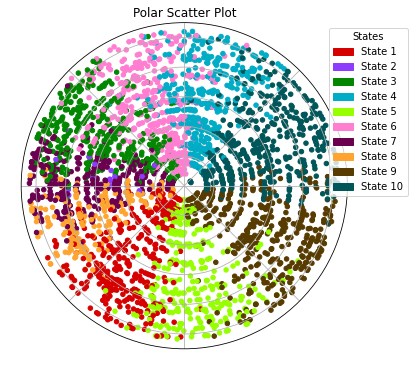

In [12]:
plot_polar_scatter(y, states_head)

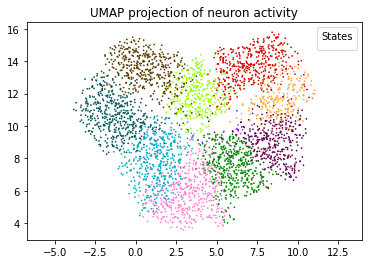

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorcet as cc  # Assuming cc is a valid import

# Assuming `embedding`, `states_head`, and `df` are defined appropriately

states_head_pure = states_head[~np.isnan(df["headAngel"])]
custom_palette = sns.color_palette(cc.glasbey, len(np.unique(states_head_pure)))

# Create a scatter plot with labels
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[custom_palette[x] for x in states_head_pure],
    s=0.5,
    label=np.unique(states_head_pure))  # Using unique labels for the legend

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity')

# Create a legend based on the scatter plot
plt.legend(*scatter.legend_elements(), title='States')

# Show the plot
plt.show()


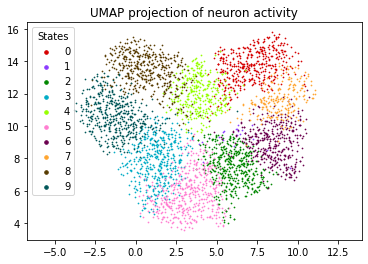

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorcet as cc  # Assuming cc is a valid import

# Assuming `embedding`, `states_head`, and `df` are defined appropriately

states_head_pure = states_head[~np.isnan(df["headAngel"])]
unique_states = np.unique(states_head_pure)
custom_palette = sns.color_palette(cc.glasbey, len(unique_states))

# Create a scatter plot with labels
scatter_handles = []
for i, state in enumerate(unique_states):
    indices = np.where(states_head_pure == state)[0]
    scatter = plt.scatter(
        embedding[indices, 0],
        embedding[indices, 1],
        c=[custom_palette[i]],
        s=0.5,
        marker = "o",
        label=state)
    scatter_handles.append(scatter)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity')

# Create a legend based on the scatter plot handles
plt.legend(handles=scatter_handles, title='States', markerscale = 5)

# Show the plot
plt.show()
